# American Sign Language (ASL) Dataset

The dataset is a collection of images of alphabets from the ASL, separated in 29 folders which represent the various classes. The training data set contains 87,000 images which are 200x200 pixels. There are **29** **classes**, of which 26 are for the letters **A-Z** and 3 classes for **SPACE**, **DELETE** and **NOTHING**.

## Objective

Given 87,000 images on ASL, the objective of this project is to develop and evaluate effective deep learning models for American Sign Language (ASL) classification, leveraging both custom convolutional neural networks (CNNs) and transfer learning with pretrained MobileNet, with the aim of optimizing accuracy, efficiency, and generalization in real-world applications.

#### Here's the base plan:

* Create a dataframe using asl alphabets images and storing image_path with label in it.
* Do EDA on it: finding out the count of images, distribution of each alphabet images, displaying 10 random images with labels, histogram of RGB channel values and analyzing it.
* Split df into 3 splits: train, validation and test and use ImageDataGenerator to reduce size from 200x200 to 96x96 and then normalize values so that its easier to train it.
* Try 3 different models: 2 custom models: 1 simple and the other little bit complex with hyperparameter tuning. 3rd model will be pretrained MobileNet model.


In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Github link: https://github.com/milanPatel001/ASL-DL-CNN

# Here's the link for the dataset: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
data_path = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train" 

2024-08-18 18:00:37.660808: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 18:00:37.660934: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 18:00:37.837787: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
imgs = []
labels = []

# Getting images and their labels.
for sub in os.listdir(data_path):
    
    sub_path = os.path.join(data_path, sub)
    if not os.path.isdir(sub_path):
        continue
  
    for f in os.listdir(sub_path):
        image_path = os.path.join(sub_path, f)
        imgs.append(image_path)
    
        labels.append(sub)
          

In [3]:
df = pd.DataFrame({'image_path': imgs, 'label': labels})

class_labels = {
    'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7,
    'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14,
    'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21,
    'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26,'nothing': 27, 'space': 28
}

label_to_alph = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space']


df.sample(10)

,image_path,label
16623,/kaggle/input/asl-alphabet/asl_alphabet_train/...,del
54040,/kaggle/input/asl-alphabet/asl_alphabet_train/...,O
10533,/kaggle/input/asl-alphabet/asl_alphabet_train/...,B
81896,/kaggle/input/asl-alphabet/asl_alphabet_train/...,nothing
6735,/kaggle/input/asl-alphabet/asl_alphabet_train/...,space
7190,/kaggle/input/asl-alphabet/asl_alphabet_train/...,space
27320,/kaggle/input/asl-alphabet/asl_alphabet_train/...,U
30688,/kaggle/input/asl-alphabet/asl_alphabet_train/...,M
56191,/kaggle/input/asl-alphabet/asl_alphabet_train/...,O
67278,/kaggle/input/asl-alphabet/asl_alphabet_train/...,C


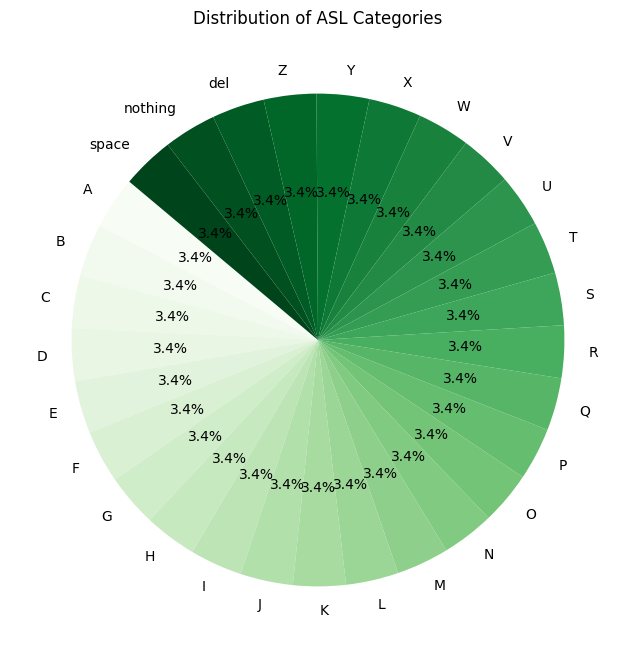

In [4]:
label_counts = df['label'].value_counts().sort_index()

cmap = plt.colormaps['Greens']

# Generate a list of colors (one for each data point)
colors = cmap(np.linspace(0, 1, len(label_counts)))

# Plotting
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title("Distribution of ASL Categories")
plt.show()

#### From the pie chart, it is quite obvious that the counts for each category (including the 26 alphabets, SPACE, NOTHING, and DELETE) are evenly distributed. This is indicated by the fact that each segment of the pie chart is of equal size, representing 3.4% of the total count.

#### Models trained on balanced data are less likely to be biased towards the majority class. This leads to fairer and more accurate predictions across all classes.

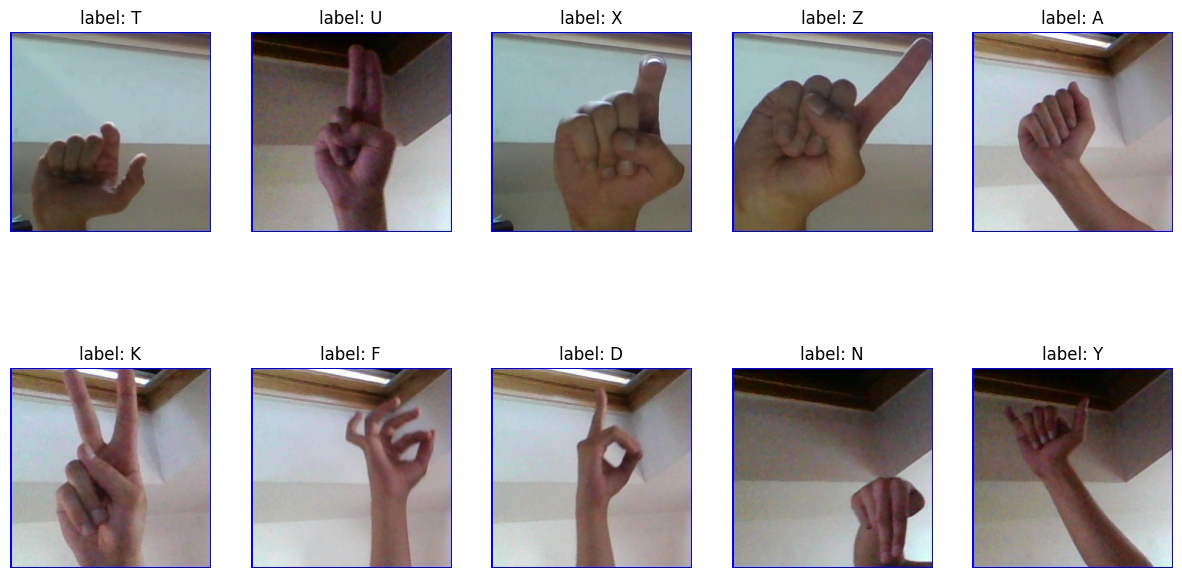

In [5]:
sampled_df = df.sample(10, random_state=42)  

# Plotting the images with their labels
plt.figure(figsize=(15, 8))

for i, (index, row) in enumerate(sampled_df.iterrows()):
    image_path = row['image_path']
    label = row['label']
    
    # Open and display image
    image = Image.open(image_path)
    plt.subplot(2, 5, i+1)  # Arrange in a 2x5 grid
    plt.imshow(image)
    plt.title(f'label: {label}')
    plt.axis('off') 

plt.show()

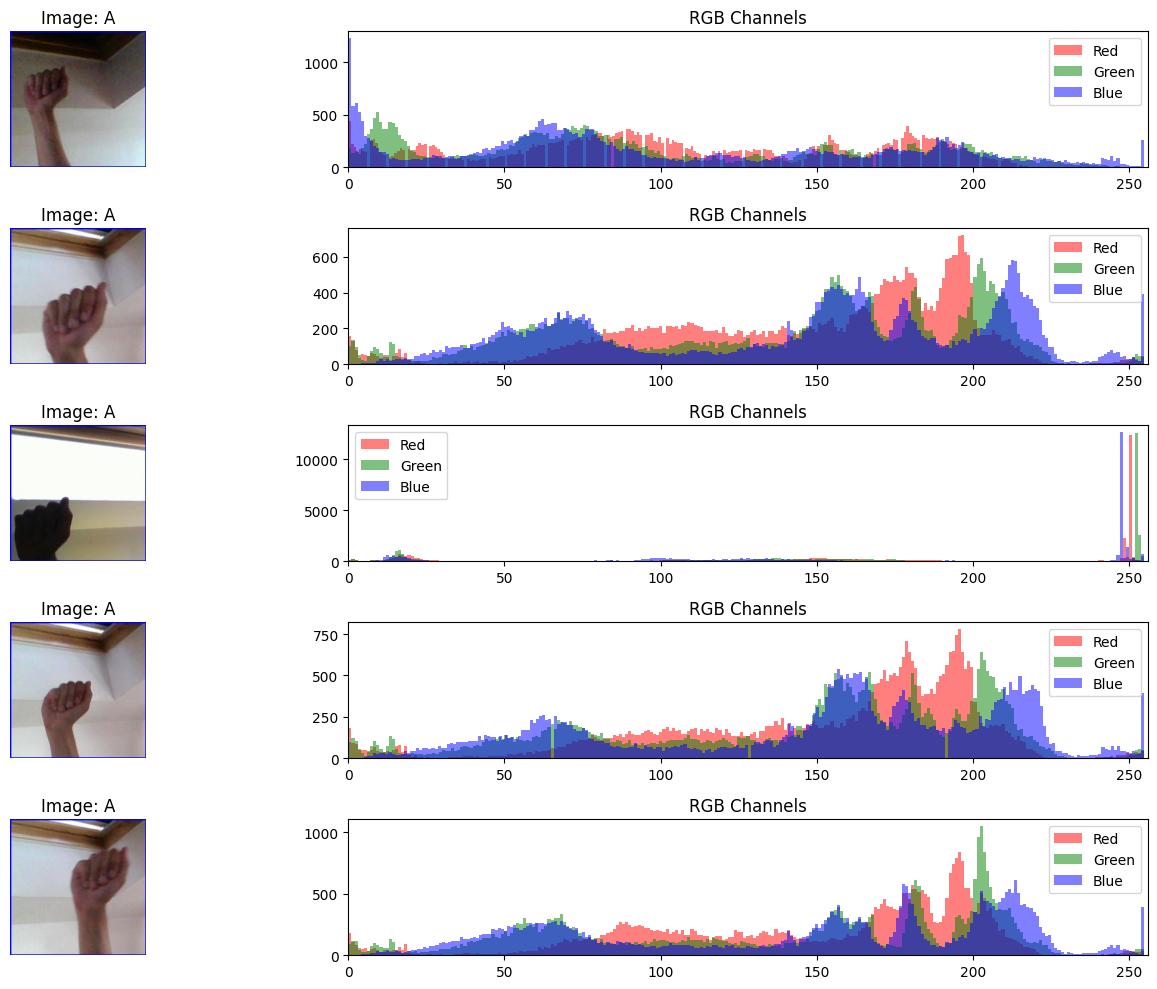

In [6]:
sampled_df = df[df['label'] == 'A'].sample(5, random_state=42) 

plt.figure(figsize=(15, 10))

for i, (index, row) in enumerate(sampled_df.iterrows()):
    image_path = row['image_path']
    label = row['label']
    
    # Open the image
    image = Image.open(image_path)
    
    # Convert image to numpy array
    image_np = np.array(image)
    
    # Separate the color channels
    red_channel = image_np[:, :, 0]
    green_channel = image_np[:, :, 1]
    blue_channel = image_np[:, :, 2]
    
    # Plot the image
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(image)
    plt.title(f"Image: {label}")
    plt.axis('off')
    
    # Plotting the RGB values in the same plot
    plt.subplot(5, 2, 2*i+2)
    plt.hist(red_channel.ravel(), bins=256, color='red', alpha=0.5, label='Red')
    plt.hist(green_channel.ravel(), bins=256, color='green', alpha=0.5, label='Green')
    plt.hist(blue_channel.ravel(), bins=256, color='blue', alpha=0.5, label='Blue')
    plt.title("RGB Channels")
    plt.xlim([0, 256])
    plt.legend()

plt.tight_layout()
plt.show()

#### The histograms show different patterns for each image even though they all represent letter 'A', indicating variations in color distribution and intensity. 

#### Some histograms have distinct peaks, while others show more spread-out distributions. The blue channel often has a prominent peak in the lower-mid range, which could correspond to the background color. Red and green channels show varying patterns, likely representing the skin tones and lighting conditions.

#### The third histogram appears quite different from the others, with very high peaks at the extreme right. This confirms that there might be images that are overexposured or underexposed.


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

train_df, rest_df = train_test_split(df, test_size=0.6, stratify=df['label'])
val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'])

datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None, 
    x_col='image_path',
    y_col='label',
    target_size=(96, 96), 
    batch_size=64,
    workers=4, 
    use_multiprocessing=True,
    class_mode='categorical',  
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=None, 
    x_col='image_path',
    y_col='label',
    target_size=(96, 96),  
    batch_size=64,
    workers=4, 
    use_multiprocessing=True,
    class_mode='categorical',  
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None, 
    x_col='image_path',
    y_col='label',
    target_size=(96, 96),  
    batch_size=1,
    workers=4, 
    use_multiprocessing=True,
    class_mode=None,
    shuffle=False
)

Found 34800 validated image filenames belonging to 29 classes.
Found 69600 validated image filenames belonging to 29 classes.
Found 17400 validated image filenames.


## Model 1

**Convolutional layers**: The model uses three convolutional layers with increasing filter counts (32, 64, 128). This allows the network to learn hierarchical features, from simple edges to more complex patterns.

**Max pooling**: After each convolutional layer, max pooling reduces spatial dimensions, making the model more computationally efficient and helping to achieve spatial invariance.

**ReLU activation**: Used in convolutional layers, ReLU helps introduce non-linearity and can help mitigate the vanishing gradient problem.

**Dropout**: The 50% dropout before the final layer helps prevent overfitting by randomly deactivating half of the neurons during training.

**Multiclass output using softmax**: The final dense layer with softmax activation is appropriate for multiclass classification.

In [8]:
model1 = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(29, activation='softmax')
])


model1.compile(loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 29)             │       371,229 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 464,477 (1.77 MB)

 Trainable params: 464,477 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model1.fit(train_generator, epochs=7, validation_data=validation_generator)

Epoch 1/7


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/544 ━━━━━━━━━━━━━━━━━━━━ 1:23:42 9s/step - accuracy: 0.0469 - loss: 0.7056

I0000 00:00:1724004463.208036     124 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724004463.229154     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 98/544 ━━━━━━━━━━━━━━━━━━━━ 2:30 338ms/step - accuracy: 0.0419 - loss: 0.1996

W0000 00:00:1724004496.018239     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


543/544 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.0962 - loss: 0.1609

W0000 00:00:1724004633.444013     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


544/544 ━━━━━━━━━━━━━━━━━━━━ 433s 781ms/step - accuracy: 0.0965 - loss: 0.1608 - val_accuracy: 0.4019 - val_loss: 0.1046
Epoch 2/7
544/544 ━━━━━━━━━━━━━━━━━━━━ 140s 256ms/step - accuracy: 0.4874 - loss: 0.0933 - val_accuracy: 0.7467 - val_loss: 0.0565
Epoch 3/7
544/544 ━━━━━━━━━━━━━━━━━━━━ 148s 270ms/step - accuracy: 0.7378 - loss: 0.0561 - val_accuracy: 0.8615 - val_loss: 0.0357
Epoch 4/7
544/544 ━━━━━━━━━━━━━━━━━━━━ 132s 241ms/step - accuracy: 0.8537 - loss: 0.0368 - val_accuracy: 0.9056 - val_loss: 0.0250
Epoch 5/7
544/544 ━━━━━━━━━━━━━━━━━━━━ 133s 243ms/step - accuracy: 0.9068 - loss: 0.0257 - val_accuracy: 0.9543 - val_loss: 0.0158
Epoch 6/7
544/544 ━━━━━━━━━━━━━━━━━━━━ 134s 245ms/step - accuracy: 0.9396 - loss: 0.0195 - val_accuracy: 0.9573 - val_loss: 0.0136
Epoch 7/7
544/544 ━━━━━━━━━━━━━━━━━━━━ 137s 250ms/step - accuracy: 0.9536 - loss: 0.0158 - val_accuracy: 0.9731 - val_loss: 0.0106


In [10]:
def plot_loss(history, label=None):
    plt.figure(figsize=(8, 6))

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss {f"({label})" if label else ""}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

def plot_accuracy(history, label=None):

    plt.figure(figsize=(8, 6))

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy {f"({label})" if label else ""}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

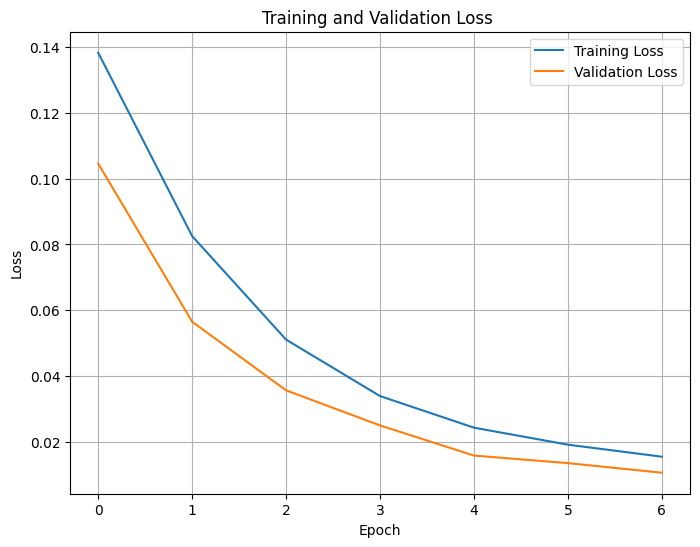

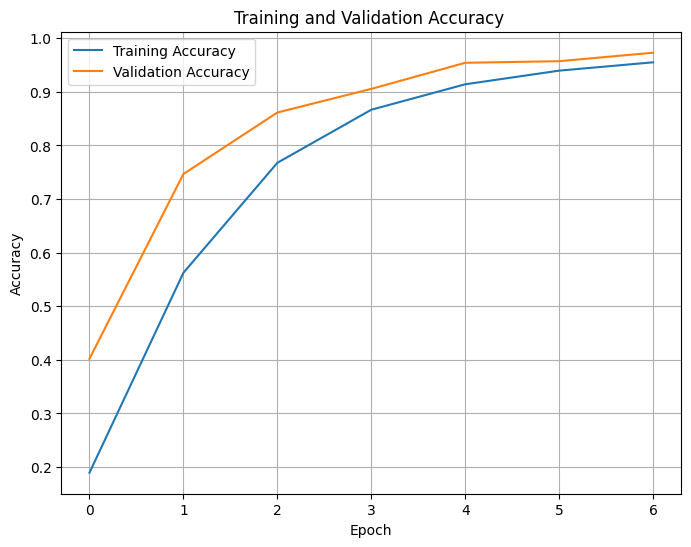

In [11]:
plot_loss(history)
plot_accuracy(history)

#### Training Loss:
The training loss starts high but decreases steadily throughout the epochs. It does not reach as low a value as in the first graph, suggesting that the model is not overfitting as much.
#### Validation Loss:
The validation loss decreases more smoothly without the large spikes seen in the first graph. The gap between training and validation loss narrows towards the end, which is a good sign of the model generalizing well.
#### Training Accuracy:
The training accuracy steadily increases but doesn't reach as high as in the first graph, suggesting a more controlled learning process.
#### Validation Accuracy:
The validation accuracy follows the training accuracy more closely, with no significant drops, indicating better generalization and stability across epochs

17400/17400 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step


<Figure size 800x800 with 0 Axes>

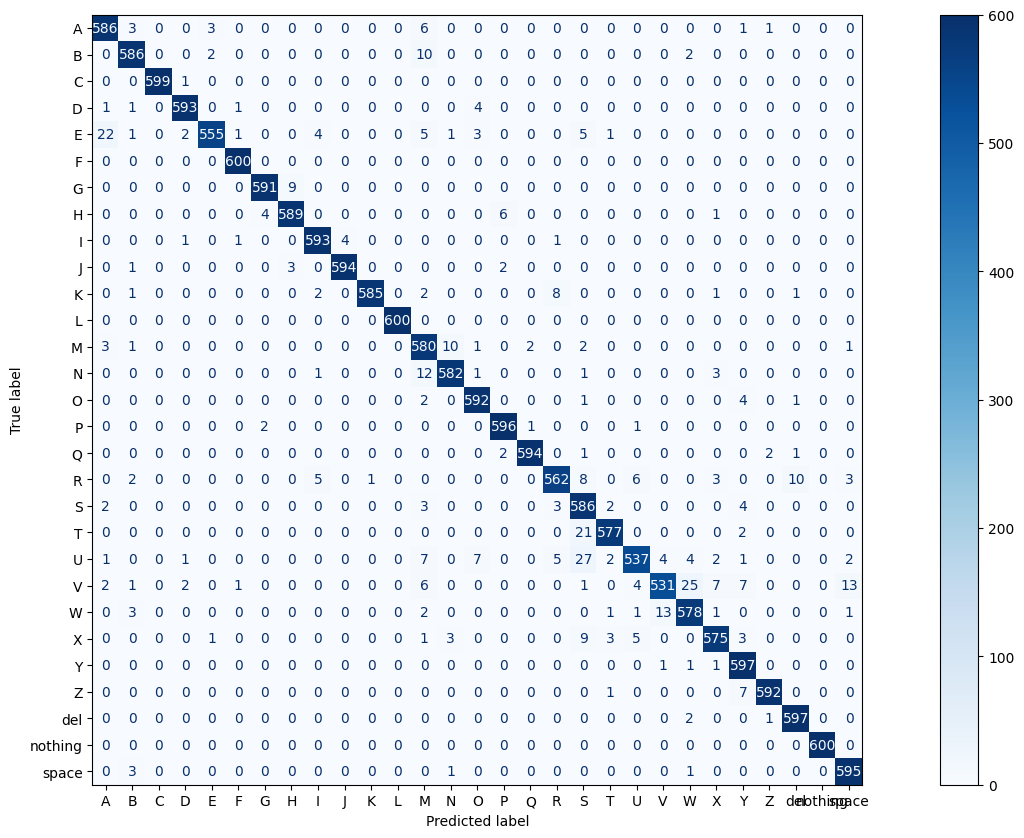

In [13]:
predictions = model1.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

predicted_labels = []
for p in predicted_classes:
    predicted_labels.append(label_to_alph[p])

cm = confusion_matrix(test_df['label'], predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_to_alph)


plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues')

fig = disp.ax_.get_figure() 
fig.set_figwidth(20)
fig.set_figheight(10)  

plt.show()


## Model 2

This model (model2) is a deeper and more complex version of the previous architecture. With more convolutional layers, this model can potentially learn more complex features. Adam optimizer is also used which can adapt the learning rate during training. Also Batch normalizer is used to speed up the model's training time.

In [14]:
model2 = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Flatten(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(29, activation='softmax')
])


model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 147456)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 147456)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │     9,437,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 29)             │         1,885 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,994,717 (38.13 MB)

 Trainable params: 9,994,589 (38.13 MB)

 Non-trainable params: 128 (512.00 B)

In [15]:
history = model2.fit(train_generator, epochs=7, validation_data=validation_generator)

Epoch 1/7
544/544 ━━━━━━━━━━━━━━━━━━━━ 181s 290ms/step - accuracy: 0.3316 - loss: 0.1387 - val_accuracy: 0.6275 - val_loss: 0.0803
Epoch 2/7
544/544 ━━━━━━━━━━━━━━━━━━━━ 135s 247ms/step - accuracy: 0.9119 - loss: 0.0234 - val_accuracy: 0.8449 - val_loss: 0.0401
Epoch 3/7
544/544 ━━━━━━━━━━━━━━━━━━━━ 134s 246ms/step - accuracy: 0.9712 - loss: 0.0105 - val_accuracy: 0.9714 - val_loss: 0.0098
Epoch 4/7
544/544 ━━━━━━━━━━━━━━━━━━━━ 144s 265ms/step - accuracy: 0.9859 - loss: 0.0063 - val_accuracy: 0.9602 - val_loss: 0.0156
Epoch 5/7
544/544 ━━━━━━━━━━━━━━━━━━━━ 139s 254ms/step - accuracy: 0.9896 - loss: 0.0051 - val_accuracy: 0.9122 - val_loss: 0.0384
Epoch 6/7
544/544 ━━━━━━━━━━━━━━━━━━━━ 137s 251ms/step - accuracy: 0.9938 - loss: 0.0042 - val_accuracy: 0.9772 - val_loss: 0.0117
Epoch 7/7
544/544 ━━━━━━━━━━━━━━━━━━━━ 139s 254ms/step - accuracy: 0.9956 - loss: 0.0035 - val_accuracy: 0.9194 - val_loss: 0.0325


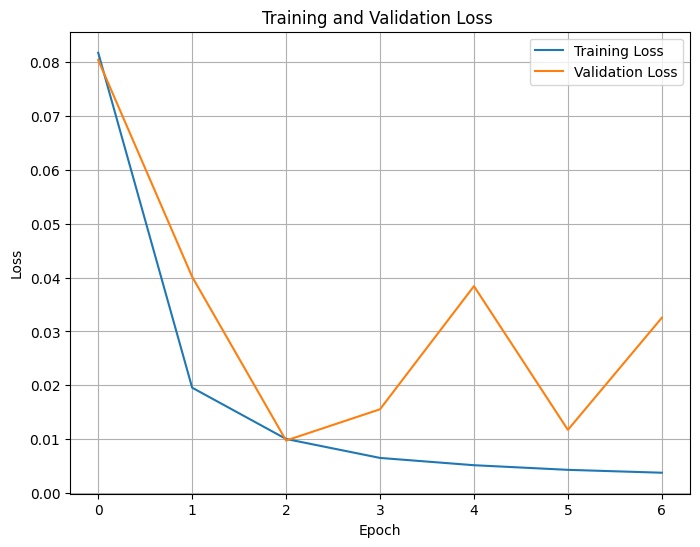

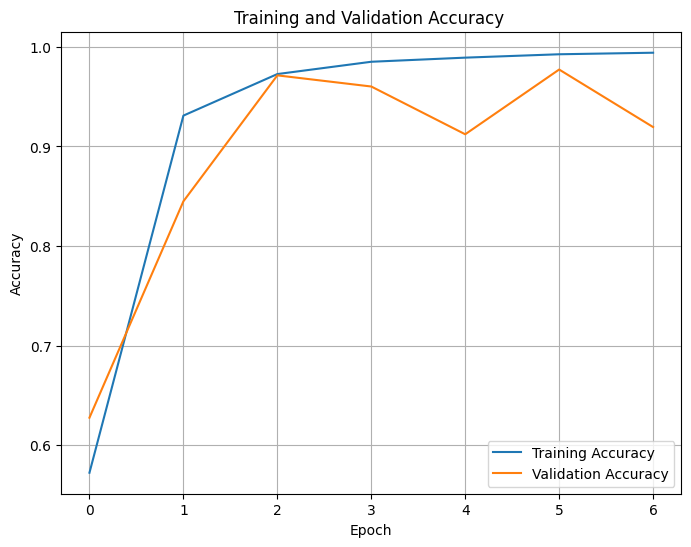

In [16]:
plot_loss(history)
plot_accuracy(history)

### The complexity of Model 2 (with more layers and filters) likely contributed to the overfitting observed in the graph. The training accuracy reached near 100% quickly, while validation accuracy fluctuated, and validation loss spiked.

17400/17400 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step


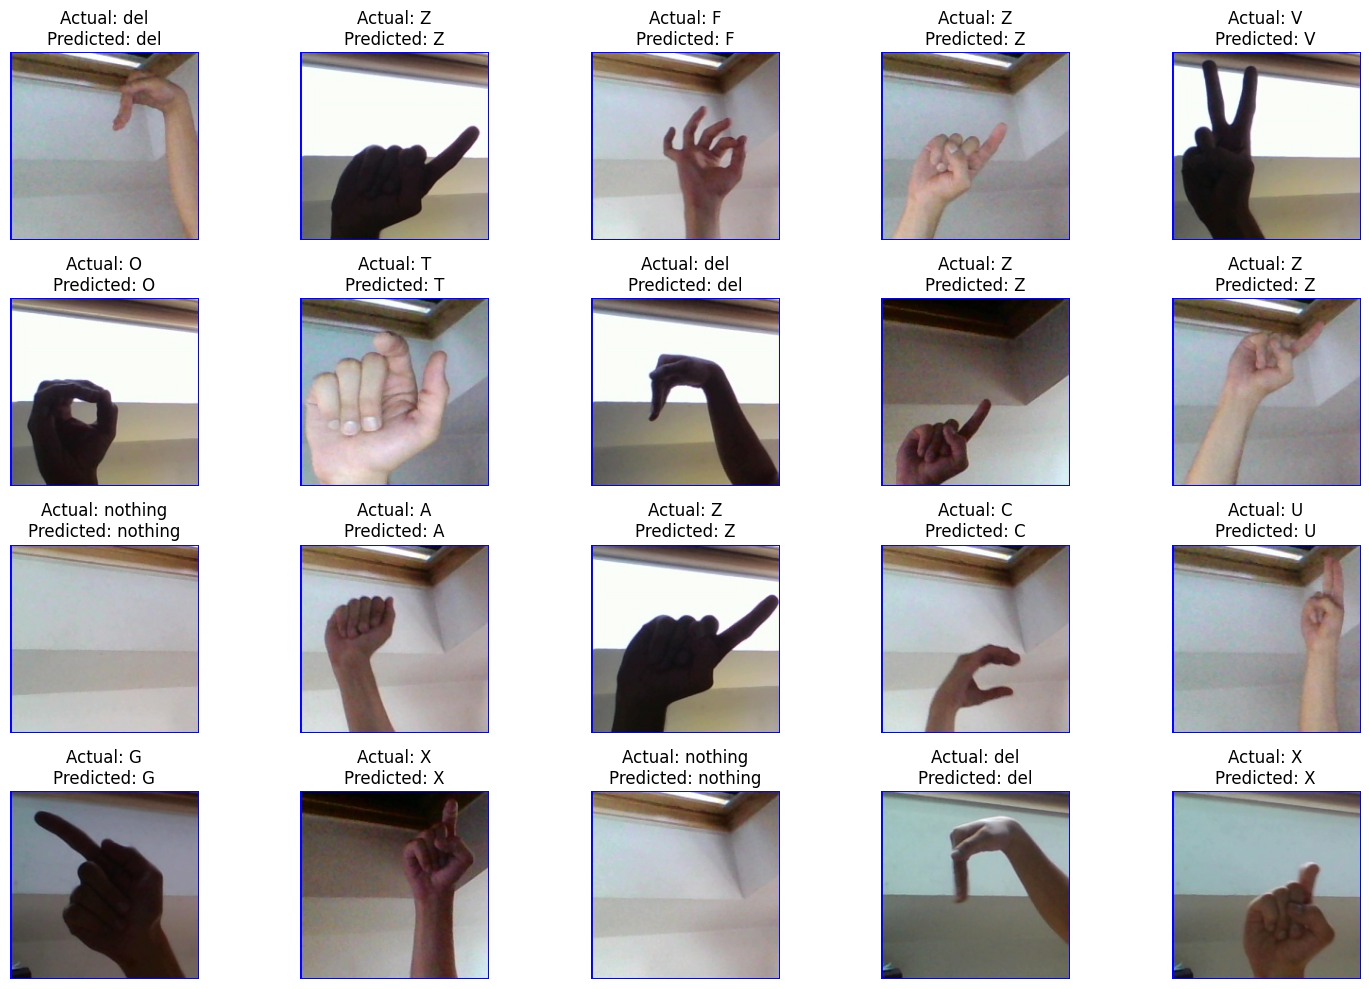

In [17]:
predictions = model2.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Get the predicted class indices

# Display the test images with their predicted labels
plt.figure(figsize=(15, 10))
for i in range(20): 
    path = test_df.iloc[i]['image_path']
    img = plt.imread(path)
    predicted_label = predicted_classes[i]

    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    
    
    plt.title(f"Actual: {test_df.iloc[i]['label']}\nPredicted: {label_to_alph[predicted_label]}")
   
    plt.axis('off')

plt.tight_layout()
plt.show()

### Now, let's try to do hyperparameter tuning of model2

In [18]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization

dropout_rate = [0.3, 0.5]
learning_rate = [1e-2, 1e-3, 1e-4]
best_accuracy = 0
best_hyperparameters = {}

for dr in dropout_rate:
    for lr in learning_rate:
        
        print(f"Testing model with dropout={dr}, learning_rate={lr}")

        model2_mod = Sequential([
            Input(shape=(96, 96, 3)),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            Conv2D(256, (3, 3), activation='relu', padding='same'),
            Flatten(),
            Dropout(0.5),
            Dense(29, activation='softmax')
        ])


        model2_mod.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
        history = model2_mod.fit(train_generator, epochs=5, validation_data=validation_generator)
        
        val_accuracy = np.max(history.history['val_accuracy'])
        print(f"Validation accuracy: {val_accuracy}")

              
        if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_hyperparameters = {
                    'dropout': dr,
                    'learning_rate': lr
                }
        
        train_generator.reset()
        validation_generator.reset()
        
print(f"Best hyperparameters: {best_hyperparameters}")
print(f"Best validation accuracy: {best_accuracy}")

Testing model with dropout=0.3, learning_rate=0.01
Epoch 1/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 147s 260ms/step - accuracy: 0.0334 - loss: 0.9147 - val_accuracy: 0.0345 - val_loss: 0.1507
Epoch 2/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 132s 242ms/step - accuracy: 0.0345 - loss: 0.1508 - val_accuracy: 0.0345 - val_loss: 0.1507
Epoch 3/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 136s 248ms/step - accuracy: 0.0328 - loss: 0.1508 - val_accuracy: 0.0345 - val_loss: 0.1508
Epoch 4/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 135s 248ms/step - accuracy: 0.0307 - loss: 0.1509 - val_accuracy: 0.0345 - val_loss: 0.1504
Epoch 5/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 136s 249ms/step - accuracy: 0.0347 - loss: 0.1509 - val_accuracy: 0.0345 - val_loss: 0.1506
Validation accuracy: 0.03448275849223137
Testing model with dropout=0.3, learning_rate=0.001
Epoch 1/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 144s 255ms/step - accuracy: 0.3962 - loss: 0.1140 - val_accuracy: 0.9171 - val_loss: 0.0247
Epoch 2/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 138s 252ms/step - accuracy: 0.9

## Comparison of model1 and model2 peformances


### Model 1:
Strengths: Simpler, more efficient model that shows better generalization to validation data, making it more robust and likely to perform better on unseen data.
Weaknesses: Slightly lower training accuracy, but this is often acceptable if it results in better validation performance.

### Model 2:
Strengths: High capacity to learn and fit the training data, potentially useful for very large datasets or complex tasks.
Weaknesses: Prone to overfitting, as indicated by the fluctuating validation metrics. Might require more regularization (e.g., increased dropout, more batch normalization) or a more extensive dataset.

## Model 3 (Pre-trained Model)

### MobileNet: 
A type of convolutional neural network designed to be efficient and lightweight, making it ideal for mobile and embedded applications where computational resources are limited. It  is a versatile and efficient neural network architecture designed for applications where computational efficiency is crucial, without sacrificing too much in terms of performance.

By freezing the base layers, it retains the learned features from ImageNet while allowing the added dense layers to specialize in recognizing ASL signs.

In [19]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(29, activation='softmax')(x) 

model3 = Model(inputs=base_model.input, outputs=predictions)

# Freezing the layers
for layer in base_model.layers:
    layer.trainable = False
    
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model3.summary())

/tmp/ipykernel_34/1437153772.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(96, 96, 3))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 48, 48, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 48, 48, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 48, 48, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 48, 48, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 49, 49, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 24, 24, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 24, 24, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 24, 24, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 24, 24, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,768,541 (14.38 MB)

 Trainable params: 539,677 (2.06 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

None


In [20]:
model3.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)

Epoch 1/5
  4/544 ━━━━━━━━━━━━━━━━━━━━ 31s 59ms/step - accuracy: 0.0501 - loss: 5.3326

W0000 00:00:1724011681.445783     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


300/544 ━━━━━━━━━━━━━━━━━━━━ 23s 98ms/step - accuracy: 0.7199 - loss: 1.1545

W0000 00:00:1724011710.452194     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


541/544 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7984 - loss: 0.8105

W0000 00:00:1724011732.652663     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


544/544 ━━━━━━━━━━━━━━━━━━━━ 153s 270ms/step - accuracy: 0.7993 - loss: 0.8069 - val_accuracy: 0.9759 - val_loss: 0.0765
Epoch 2/5


W0000 00:00:1724011827.899319     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


544/544 ━━━━━━━━━━━━━━━━━━━━ 138s 252ms/step - accuracy: 0.9878 - loss: 0.0451 - val_accuracy: 0.9863 - val_loss: 0.0407
Epoch 3/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 136s 248ms/step - accuracy: 0.9933 - loss: 0.0239 - val_accuracy: 0.9731 - val_loss: 0.0912
Epoch 4/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 131s 240ms/step - accuracy: 0.9881 - loss: 0.0408 - val_accuracy: 0.9877 - val_loss: 0.0397
Epoch 5/5
544/544 ━━━━━━━━━━━━━━━━━━━━ 130s 238ms/step - accuracy: 0.9928 - loss: 0.0252 - val_accuracy: 0.9941 - val_loss: 0.0183


In [21]:
predictions = model3.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

17400/17400 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step


In [22]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

class_labels = {
    'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7,
    'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14,
    'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21,
    'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26,'nothing': 27, 'space': 28
}

actual_labels = []

for label in test_df['label']:
    actual_labels.append(class_labels[label])

    
report = classification_report(actual_labels, predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       600
           1       1.00      1.00      1.00       600
           2       1.00      1.00      1.00       600
           3       1.00      1.00      1.00       600
           4       0.99      1.00      0.99       600
           5       0.99      1.00      1.00       600
           6       0.97      1.00      0.98       600
           7       1.00      0.97      0.98       600
           8       1.00      0.99      1.00       600
           9       1.00      1.00      1.00       600
          10       1.00      0.97      0.99       600
          11       1.00      1.00      1.00       600
          12       1.00      1.00      1.00       600
          13       1.00      0.99      1.00       600
          14       0.99      1.00      1.00       600
          15       1.00      1.00      1.00       600
          16       1.00      1.00      1.00       600
          17       0.98    

<Figure size 800x800 with 0 Axes>

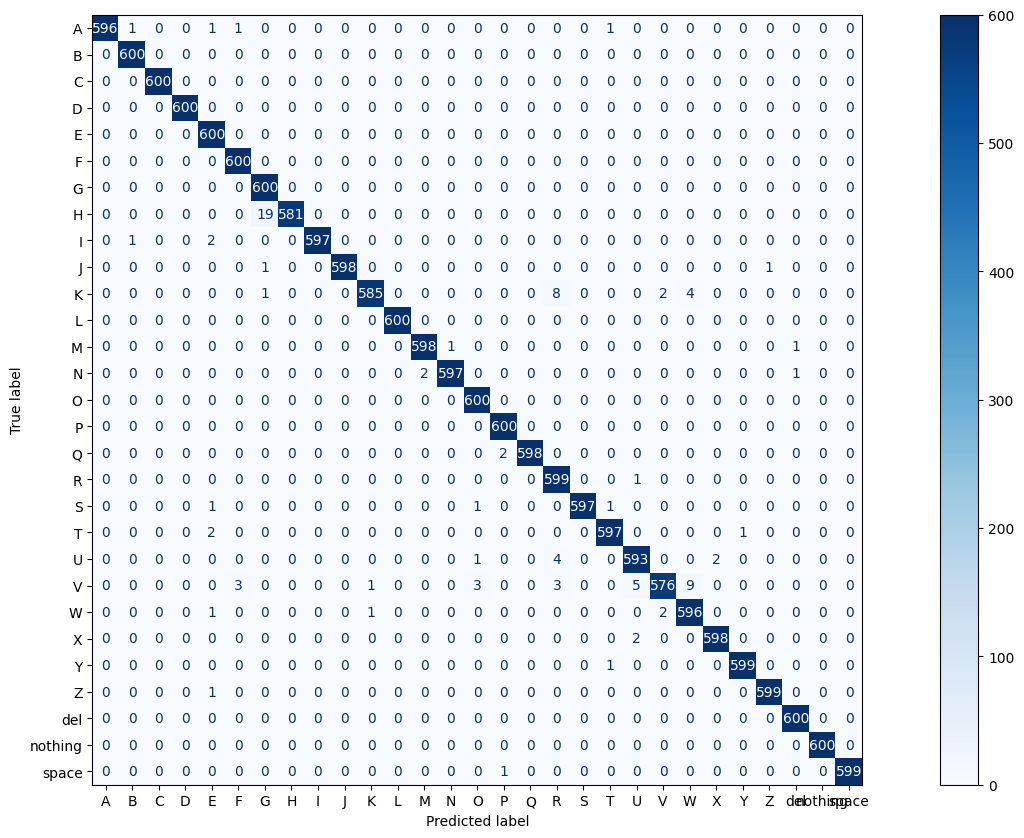

In [23]:
predicted_labels = []
for p in predicted_classes:
    predicted_labels.append(label_to_alph[p])

cm = confusion_matrix(test_df['label'], predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_to_alph)


plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues')

fig = disp.ax_.get_figure() 
fig.set_figwidth(20)
fig.set_figheight(10)  

plt.show()


## Summary

Experimented with three different models for ASL (American Sign Language) classification. 

#### Model 1: 
Provides a balanced approach, with simpler layers and better generalization, making it a reliable option.

#### Model 2: 
Offers a deeper architecture, useful for complex tasks but prone to overfitting without sufficient regularization or data.

#### Model 3 (MobileNet): 
The top performer, leveraging transfer learning to deliver near-perfect accuracy and robust performance across all classes. This model is highly recommended for real-world ASL classification tasks, especially when efficiency and accuracy are critical.

Overall, Model 3 with MobileNet stands out as the best choice, followed by Model 1 for its simplicity and stability, and Model 2 if deeper architectures are desired with appropriate measures to prevent overfitting.

## Takeaways and Future Improvements

Every model performed quite well on this dataset. This might be due to simpler and quanitity of images. The experiment highlights the power of transfer learning, with MobileNet slighlty outperforming custom architectures in both accuracy and efficiency. The custom models, showed promise but struggled with overfitting and required more epochs to achieve stability. Moving forward, improvements could include exploring data augmentation to enhance generalization, fine-tuning a portion of the MobileNet layers for better feature extraction, and experimenting with more complex custom architectures like residual or attention mechanisms to push the performance further while maintaining a balance between accuracy and training time.